# Uncapacitated Multiple Allocation HLP Problem.
### Autor: Saúl Sosa Díaz
---
## El problema.
El Problema de Ubicación de Concentradores de Múltiple Asignación Sin Capacidad (UMAHLP), un tema vital en la investigación de operativa, involucra la determinación estratégica de la ubicación óptima de concentradores (hubs) y la asignación eficiente de nodos a estos puntos. En el UMAHLP, el objetivo principal es seleccionar concentradores de una lista de ubicaciones potenciales, asignando cada nodo no concentrador a uno o más de estos hubs. El fin es minimizar el costo total, que generalmente abarca el transporte entre nodos y concentradores, y en ocasiones, los costos operativos de los hubs. A diferencia de otros desafíos en la ubicación de concentradores, el UMAHLP se distingue por no tener restricciones de capacidad, permitiendo que cada concentrador maneje cualquier volumen de tráfico o demanda. Además, la característica de múltiple asignación permite que un nodo se asocie con más de un concentrador, incrementando la flexibilidad.

Consideremos un conjunto de nodos $ V$ y un número $ p$ de hubs por abrir en un grafo completo $ G=(V,A)$, donde $ |V|=n$. La cantidad de producto transportado del nodo $ i \in V$ al nodo $ j \in V$ se define como $ d_{ij}$. El costo unitario de transporte a lo largo del arco $ (i,j) \in A$ se representa por $ c_{ij}$.

Para modelar el costo de transporte, se introducen los siguientes factores, dependiendo del tipo de arco $ (i,j)$:

* Un factor de descuento $ \alpha$, donde $ 0 \le \alpha \le 1$, se aplica cuando el arco conecta dos hubs.
* Un factor de recolección $ \chi$, con $ \chi > \alpha$, se utiliza cuando el arco va de un nodo origen a un hub.
* Un factor de distribución $\delta$, $\delta > \alpha$, si el arco va de un hub a un nodo destino.

Tras establecer claramente el problema, estamos listos para abordar la construcción del modelo matemático.

**Variables**
 
 * $y_{k}$ es 1 si se abre un hub en $k\in V$, y 0 en otro caso.
 * $X_{ijkm}$ es una variable continua que representa la fracción de la demanda $w_{ij}$ que se envía de $i$ a $j$ a través de los hubs $k$ y $m$. 

**Función Objetivo**
$$
\begin{align}
    \min & \sum_{i\in V}\sum_{j\in V}\sum_{k\in V}\sum_{m\in V}w_{ij}C_{ijkm}X_{ijkm}  + \sum_{k \in V}f_k y_k
\end{align}
$$

**Sujeto a**:
$$
\begin{array}{cc}
&\sum_{k \in V}\sum_{m \in V}X_{ijkm} = 1 & \forall i,j \in V\\
&X_{ijkm} <= y_{k} & \forall i, j, k, m \in V &\\
&X_{ijkm} <= y_{m} & \forall i, j, k, m \in V &\\
& \sum_{k \in V} y_{k} <= p \\
&x_{ijkm} \geq 0 & \forall i,j,k,m \in V \\
& y_{k} \in \{0,1\} & \forall k \in V\\
\end{array}
$$


## Resolución del problema.
Importamos los paquetes necesarios.

In [8]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")


using JuMP, GLPK, Random, Plots, Random, LinearAlgebra



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


### Introducimos los datos.

In [9]:
Random.seed!(12344213) # Set seed for reproducibility

# Initial parameters
n = 10  # Number of nodes
p = 4   # Number of hubs to open
V = 1:n # Set of nodes
w = rand(1:10, n, n) # Random demand
f = rand(1:10, n)    # Costs to establish a hub
c = rand(1:10, n, n) # Transportation costs
for i in V
    c[i,i] = 0
    w[i,i] = 0
end

# Ensure that c satisfies the triangle inequality
for i in V
    for j in V
        for k in V
            c[i,j] = min(c[i,j], c[i,k] + c[k,j])
        end
    end
end

coordinates_nodes = Dict()
for i in V
    coordinates_nodes[i] = (c[i, 1], c[i, 2])
end

# Cost factors
α = 0.8 # Discount factor
χ = 1.2 # Collection factor
δ = 1.5 # Distribution factor

# Calculate adjusted transportation costs
C = zeros(n, n, n, n)
for i in V, j in V, k in V, m in V
    C[i,j,k,m] = χ * c[i,k] + α * c[k,m] + δ * c[m,j]
end


Preparamos la representación de los datos.

In [10]:
function DrawInstance(N, node_coordinates, scale_size = 1.0)
    X = [node_coordinates[n][1] for n in N]
    Y = [node_coordinates[n][2] for n in N]
    p = scatter( # Plot the clients
        X,
        Y;
        label = nothing,
        markershape = :circle,
        markercolor = :green,
        markersize = scale_size * 5
    )
    display(p)
end



function DrawSolution(y, X, N, node_coordinates, scale_size = 1.0)
    # Extract the X and Y coordinates of the nodes.
    Xn = [node_coordinates[n][1] for n in N]
    Yn = [node_coordinates[n][2] for n in N]
    # Initialize the graph
    p = plot()

    # Draw nodes
    scatter!(p, Xn, Yn; label="Nodes", markershape=:circle, markercolor=:green, markersize=scale_size * 5)

    # Draw connections between nodes and hubs
    for i in N
        for k in N
            if i != k && any(value(X[i,j,k,m]) > 0.5 for j in N, m in N)
                plot!(p, [node_coordinates[i][1], node_coordinates[k][1]], [node_coordinates[i][2], node_coordinates[k][2]];
                      color=:blue, label="", linewidth=2)
            end
        end
    end

    # Identify open hubs and draw them
    hubs = []
    for k in N
        if value(y[k]) > 0.5  # Check if the hub is open
            push!(hubs, k)
            scatter!(p, [node_coordinates[k][1]], [node_coordinates[k][2]]; label="Hub $k", markershape=:star5, markercolor=:yellow, markersize=scale_size * 10, markerstrokewidth=2)
        end
    end

    # Drawing connections between hubs
    for i in hubs
        for j in hubs
            if i != j && any(value(X[i,j,k,m]) > 0.5 for k in N, m in N)
                plot!(p, [node_coordinates[i][1], node_coordinates[j][1]], [node_coordinates[i][2], node_coordinates[j][2]];
                      color=:red, label="", linewidth=2)
            end
        end
    end

    # Adjusting the graph limits
    xmin, xmax = extrema(Xn)
    ymin, ymax = extrema(Yn)
    xlims!(p, xmin - 1, xmax + 1)
    ylims!(p, ymin - 1, ymax + 1)

    display(p)
end



DrawSolution (generic function with 2 methods)

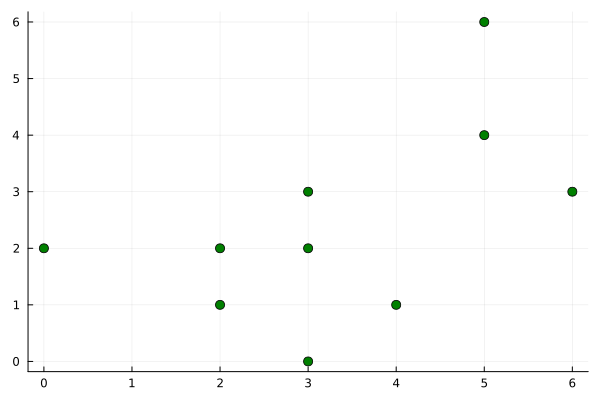

In [11]:
DrawInstance(V, coordinates_nodes)

### Construir el modelo.

In [12]:
function solveHLP()
    EPS = 0.00001
    model = Model(GLPK.Optimizer)

    # Variables
    @variable(model, y[k in V], Bin)
    @variable(model, X[i in V, j in V, k in V, m in V] >= 0)

    # Objetive
    @objective(model, Min, sum(w[i, j] * C[i, j, k, m] * X[i, j, k, m] for i in V, j in V, k in V, m in V) + sum(f[k] * y[k] for k in V))

    # Constraints
    @constraint(model, [i in V, j in V], sum(X[i, j, k, m] for k in V, m in V) == 1)
    @constraint(model, [i in V, j in V, k in V, m in V], X[i, j, k, m] <= y[k])
    @constraint(model, [i in V, j in V, k in V, m in V], X[i, j, k, m] <= y[m])
    @constraint(model, sum(y[k] for k in V) <= p)
    # Resolve model
    optimize!(model)

    # Show solutions
    if termination_status(model) == OPTIMAL
        println("Solution:")
        println("   Objective value: ", objective_value(model))
        # Display the hubs that are opened
        println("Hubs opened at the following locations:")
        for k in V
            if value(y[k]) > 0.5 # Considering y[k] as binary
                println(" - Hub at location $k")
            end
        end

        # Display the demand routes
        println("\nDemand routes:")
        for i in V, j in V
            if i != j
                println("Route from $i to $j:")
                for k in V, m in V
                    if value(X[i,j,k,m]) > 0 && k != m
                        println("   Passes through hubs $k and $m")
                    elseif value(X[i,j,k,m]) > 0 && k == m
                        println("   Passes through hub $k")
                    end
                end
            end
        end

        DrawSolution(value.(y),value.(X), V, coordinates_nodes)
    else
        println("infeasible")
        return -1
    end 
end

solveHLP (generic function with 1 method)

Resolvemos y mostramos el resultado.

Solution:
   Objective value: 1965.3999999999996
Hubs opened at the following locations:
 - Hub at location 3
 - Hub at location 5
 - Hub at location 9
 - Hub at location 10

Demand routes:
Route from 1 to 2:
   Passes through hub 5
Route from 1 to 3:
   Passes through hubs 9 and 3
Route from 1 to 4:
   Passes through hub 5
Route from 1 to 5:
   Passes through hub 5
Route from 1 to 6:
   Passes through hub 5
Route from 1 to 7:
   Passes through hub 5
Route from 1 to 8:
   Passes through hub 5
Route from 1 to 9:
   Passes through hub 9
Route from 1 to 10:
   Passes through hubs 5 and 10
Route from 2 to 1:
   Passes through hub 5
Route from 2 to 3:
   Passes through hubs 5 and 3
Route from 2 to 4:
   Passes through hub 5
Route from 2 to 5:
   Passes through hub 5
Route from 2 to 6:
   Passes through hub 5
Route from 2 to 7:
   Passes through hub 5
Route from 2 to 8:
   Passes through hub 5
Route from 2 to 9:
   Passes through hub 9
Route from 2 to 10:
   Passes through hubs 5 and 10
Rout

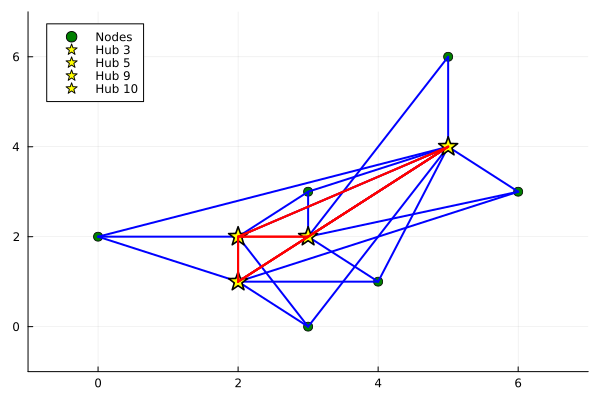

In [13]:
solveHLP()